# Sailing Environment Tutorial

Welcome to this tutorial on the sailing environment! In this notebook, we'll explore a reinforcement learning environment where an agent must learn to navigate a sailing boat from a starting point to a goal, taking into account wind conditions and sailing physics.

## 1. Setup and Imports

First, let's import all the necessary modules. Our environment uses standard scientific Python libraries along with custom modules for the sailing environment and agents.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))

# Import the environment and evaluation modules
from env_sailing import SailingEnv
from evaluation import evaluate_agent, visualize_trajectory
from sailing_physics import generate_velocity_polar_plot, generate_efficiency_curve

# Import the base agent and specific agents
from agents.base_agent import BaseAgent
from agents.agent_north import AgentNorth
from agents.agent_random import AgentRandom
from agents.agent_smart import AgentSmart

## 2. Understanding Wind Scenarios

In this environment, wind conditions are defined through scenarios. A scenario consists of two main components:
1. `wind_init_params`: Parameters that define the initial wind field
2. `wind_evol_params`: Parameters that control how the wind evolves over time

Let's create a scenario with stable wind conditions (no variations or evolution) to start with:

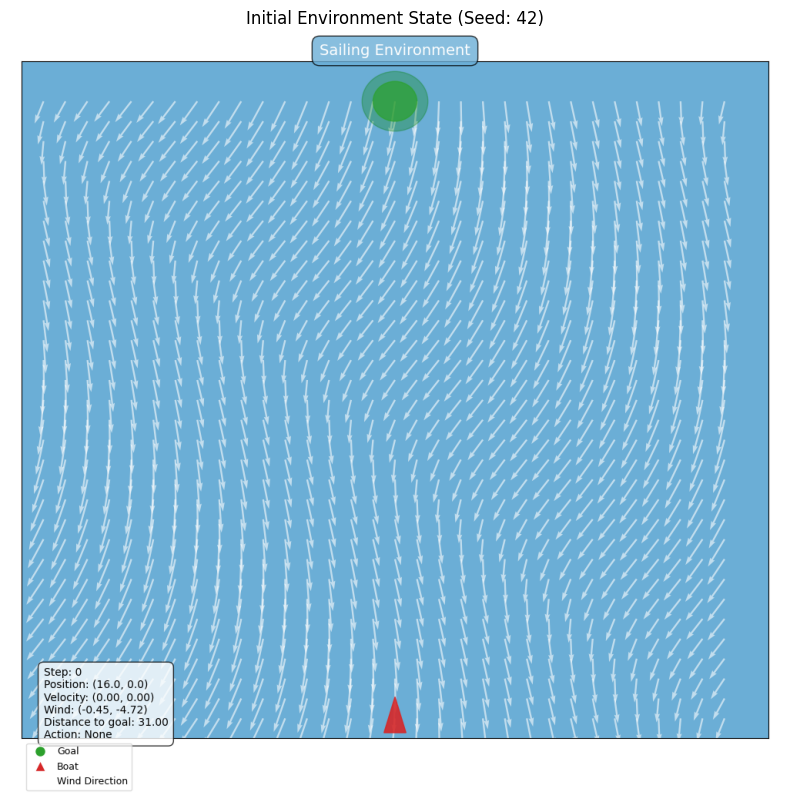

Initial position: [16  0]
Initial wind at position: [-0.44574099 -4.72406105]


In [2]:
# Define a stable wind scenario
stable_wind_scenario = {
    'wind_init_params': {
        'base_speed': 4.0,
        'base_direction': (-0.2, -0.9),  # More northern-oriented
        'pattern_scale': 32,
        'pattern_strength': 0.4,     # No variation for stable wind
        'strength_variation': 0.2,   # No variation for stable wind
        'noise': 0.0                 # No noise for stable wind
    },
    'wind_evol_params': {
        'wind_change_prob': 0.0,     # No wind changes
        'pattern_scale': 32,
        'perturbation_angle_amplitude': 0.0,
        'perturbation_strength_amplitude': 0.0,
        'wind_evolution_bias': (0.0, 0.0),
        'bias_strength': 0.0
    },
    'env_params': {
        'grid_size': (32, 32),
        'wind_grid_density': 25,    # Fewer arrows = clearer visualization
        'wind_arrow_scale': 100,    # Larger value = smaller arrows
        'render_mode': "rgb_array"
    }
}

# Create environment with the scenario
env = SailingEnv(**stable_wind_scenario['env_params'],
                 wind_init_params=stable_wind_scenario['wind_init_params'],
                 wind_evol_params=stable_wind_scenario['wind_evol_params'])

# Set the seed for reproducibility
env.seed(42)  # Choose any seed you want
observation, info = env.reset()  # The reset will use the seed we just set

# Display initial state
plt.figure(figsize=(10, 10))
plt.imshow(env.render())
plt.axis('off')
plt.title('Initial Environment State (Seed: 42)')  # Added seed to title for clarity
plt.show()

# Print some info about the initial state
print(f"Initial position: {info['position']}")
print(f"Initial wind at position: {info['wind']}")

## 3. Understanding Sailing Physics

Before we test different agents, it's important to understand how sailing physics works in this environment. The boat's speed depends on its angle relative to the wind direction, following specific sailing efficiency patterns.

Let's visualize these patterns using a polar plot and examine efficiency values for different angles:

<Figure size 1000x1000 with 0 Axes>

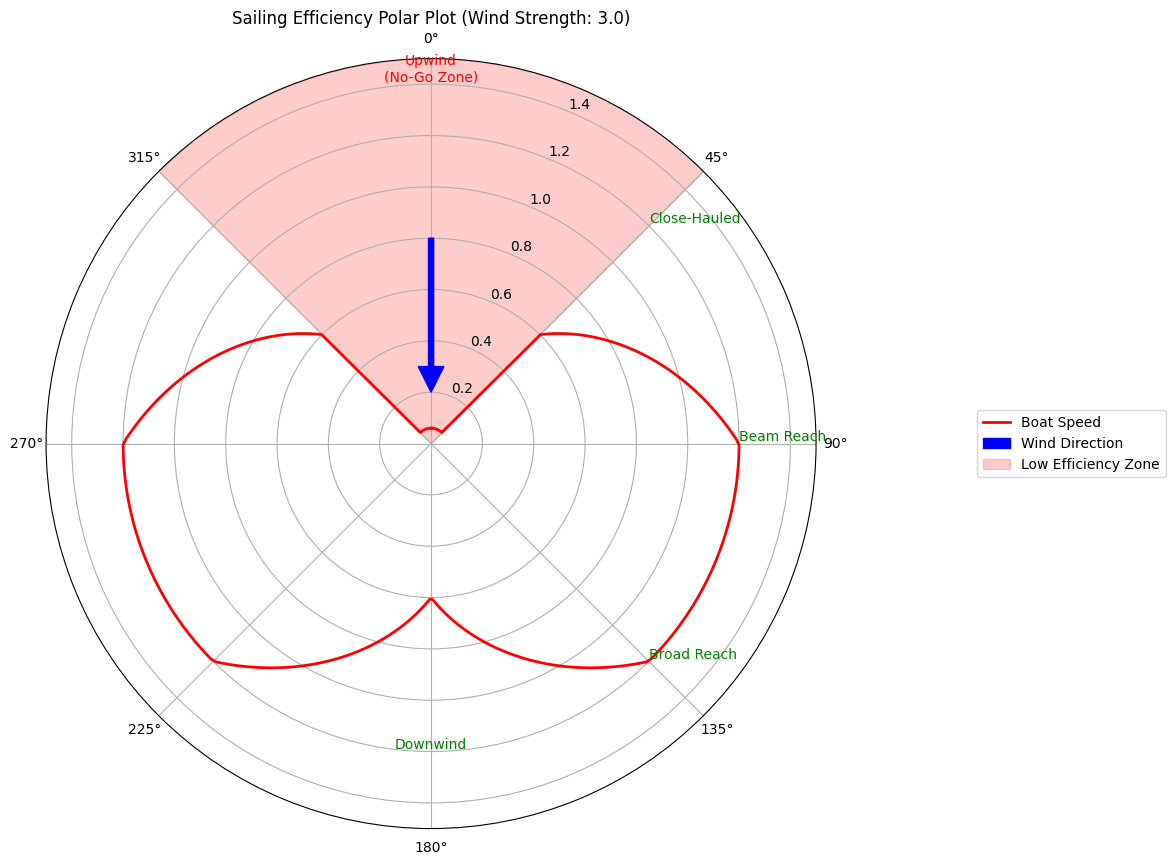


Sailing efficiency curve:


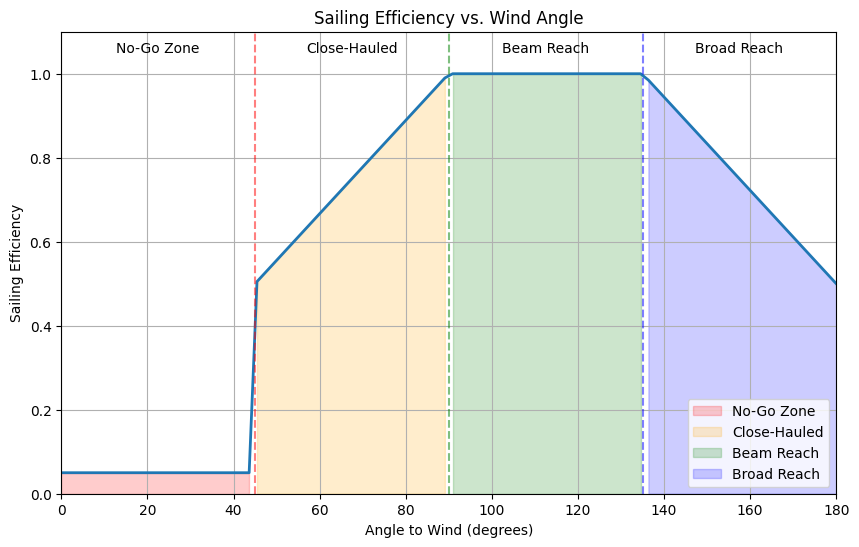

In [3]:
# Generate and display the velocity polar plot
plt.figure(figsize=(10, 10))
wind_strength = 3.0  # Using a stronger wind for better visualization
generate_velocity_polar_plot(wind_strength=wind_strength)
plt.title(f'Sailing Efficiency Polar Plot (Wind Strength: {wind_strength})')
plt.show()

# Demonstrate sailing efficiency with a polar plot
wind_vector = np.array([0.0, -1.0])  # Wind coming from the top
print("\nSailing efficiency curve:")
generate_efficiency_curve()
plt.show()

## 4. Testing Simple Agents

Let's start by testing a very simple agent that always tries to go north (straight towards the goal). This will help us understand the basic interaction between the agent and the environment.

### 4.1 North Agent
The North agent always tries to move straight up, regardless of wind conditions. This strategy works in some conditions but fails when sailing directly into the wind (the "no-go zone").

In [4]:
# Create north agent
agent_north = AgentNorth()

# Evaluate the north agent
north_results = evaluate_agent(
    agent=agent_north,
    scenario=stable_wind_scenario,
    seeds=42,
    max_horizon=100,
    verbose=True,
    render=True,  # Enable rendering
    full_trajectory=True  # Store the full trajectory for visualization
)

# Visualize the trajectory
visualize_trajectory(north_results, env, with_slider=True)

Evaluating seeds:   0%|          | 0/1 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=0, description='Step:', max=99), Output()), _dom_classes=('widget-intera…

## 5. Testing Smart Sailing Strategies

Now let's test a smarter agent that understands sailing physics and uses tacking (zigzag pattern) to navigate upwind. This strategy is commonly used by sailors when they need to move against the wind.

### 5.1 Smart Agent
The Smart agent implements a tacking strategy, changing its direction based on its position relative to the goal and the current wind conditions.

In [5]:
# Create smart agent
agent_smart = AgentSmart()

# Evaluate the smart agent
smart_results = evaluate_agent(
    agent=agent_smart,
    scenario=stable_wind_scenario,
    seeds=42,
    max_horizon=100,
    verbose=True,
    render=True,
    full_trajectory=True
)

# Visualize the trajectory
visualize_trajectory(smart_results, env, with_slider=True)

Evaluating seeds:   0%|          | 0/1 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=0, description='Step:', max=48), Output()), _dom_classes=('widget-intera…

## 6. Comparing Different Agents

Finally, let's compare all our agents (including a random agent) to see how different strategies perform. This comparison will help us understand the importance of proper sailing strategy.

We'll evaluate each agent on the same wind conditions for a fair comparison:

In [6]:
# Create different agents
agents = {
    'North': AgentNorth(),
    'Smart': AgentSmart(),
    'Random': AgentRandom()
}

# Compare the agents
results = {}
for agent_name, agent in agents.items():
    print(f"\nEvaluating {agent_name}...")
    episode_results = evaluate_agent(
        agent=agent,
        scenario=stable_wind_scenario,
        seeds=42,
        max_horizon=100,
        verbose=True,
        render=True,
        full_trajectory=True
    )
    results[agent_name] = episode_results

# Display results
for agent_name, episode_results in results.items():
    print(f"\n{agent_name} Results:")
    # Success is when any reward in the episode is positive (meaning goal was reached)
    rewards = episode_results['rewards']
    steps = episode_results['mean_steps']
    discounted_reward = episode_results['mean_reward']
    
    if any(r > 0 for r in rewards):
        print(f"Succeeded! Reached goal in {steps:.0f} steps, "
              f"Mean Discounted Reward: {discounted_reward:.2f}")
    else:
        print(f"Failed to reach goal (max {steps:.0f} steps), "
              f"Mean Discounted Reward: {discounted_reward:.2f}")
    
    # Visualize the trajectory
    visualize_trajectory(episode_results, env, with_slider=True)


Evaluating North...


Evaluating seeds:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluating Smart...


Evaluating seeds:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluating Random...


Evaluating seeds:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/t.rahier/code_project_v0/Sailing_project_v1/src/env_sailing.py:537: RuntimeWarning: invalid value encountered in divide
  direction_normalized = direction / np.linalg.norm(direction)



North Results:
Failed to reach goal (max 100 steps), Mean Discounted Reward: 0.00


interactive(children=(IntSlider(value=0, description='Step:', max=99), Output()), _dom_classes=('widget-intera…


Smart Results:
Succeeded! Reached goal in 40 steps, Mean Discounted Reward: 67.57


interactive(children=(IntSlider(value=0, description='Step:', max=39), Output()), _dom_classes=('widget-intera…


Random Results:
Failed to reach goal (max 100 steps), Mean Discounted Reward: 0.00


interactive(children=(IntSlider(value=0, description='Step:', max=99), Output()), _dom_classes=('widget-intera…

## 7. Conclusion

In this tutorial, we've explored:
1. How to set up and configure the sailing environment
2. The physics of sailing and how efficiency varies with wind angle
3. Different agent strategies, from simple (north-seeking) to smart (tacking)
4. How to evaluate and compare different agents

This environment provides an interesting challenge for reinforcement learning, as agents must learn to:
- Navigate in a continuous state space
- Handle wind conditions that affect movement
- Develop strategies like tacking to reach the goal efficiently
- Balance short-term progress with long-term planning

Try experimenting with different wind scenarios and agent parameters to better understand the challenges of sailing navigation!